# Optical Composite Augmentation Demonstration
This work calls on the astroaugmentations package and the classes therein.
Uses tensorflow to load the images.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import albumentations as A

import astroaugmentations as AA
from astroaugmentations.datasets.galaxy_mnist_tf import GalaxyMNIST

import matplotlib.pyplot as plt
import numpy as np

# Composing a Custom Transformation

In [2]:
dl_config = tfds.download.DownloadConfig(
                extract_dir='./data/GalaxyMNIST/raw')
ds = tfds.load('GalaxyMNIST', data_dir='./data', download=True,
               download_and_prepare_kwargs={'download_dir':'./data/GalaxyMNIST/raw',
                                            'download_config':dl_config})
train_no_augmentation = iter(ds['train'])

generator


generator


Dataset galaxy_mnist downloaded and prepared to ./data/galaxy_mnist/0.1.0. Subsequent calls will reuse this data.


In [3]:
custom_transform = A.Compose([
    A.ToFloat(),
    A.Lambda(
        name='Adding Simulated Sources',
        image=AA.optical.SuperimposeSources(
            mode='sersic'
        ), p=1)
])

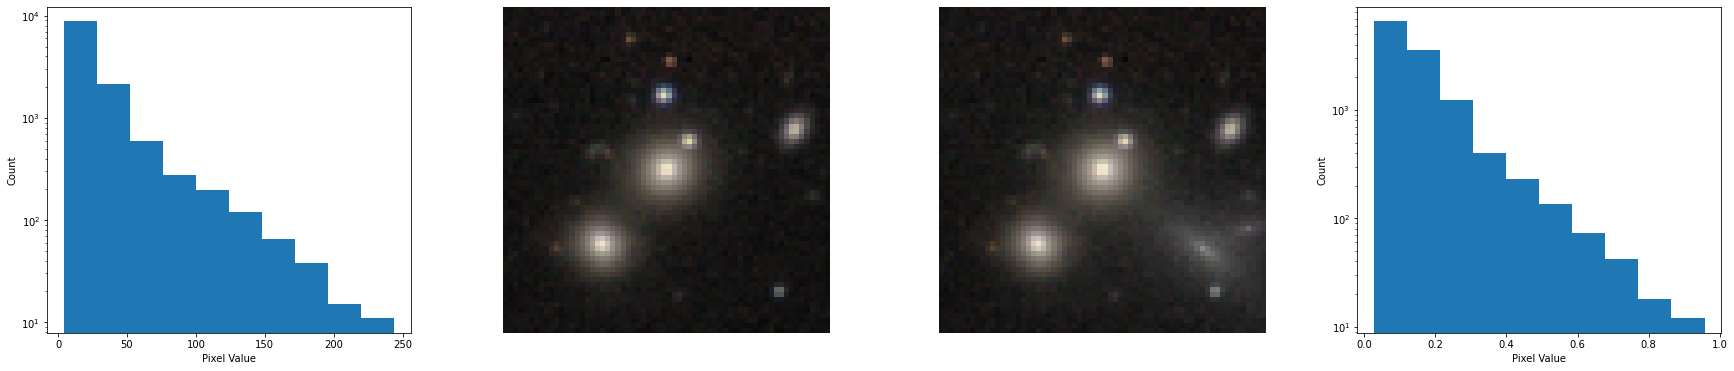

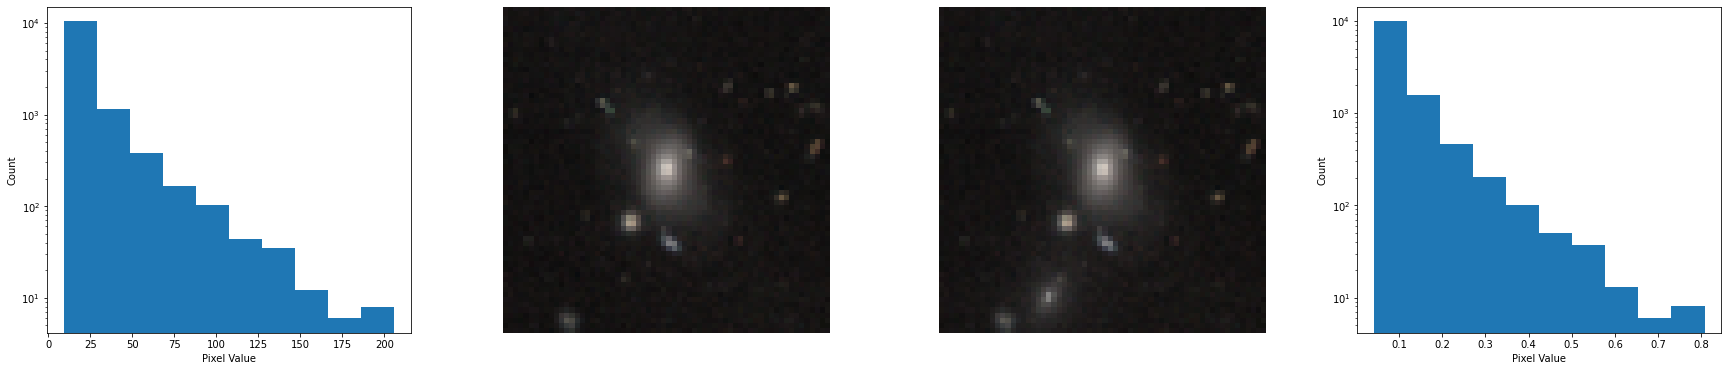

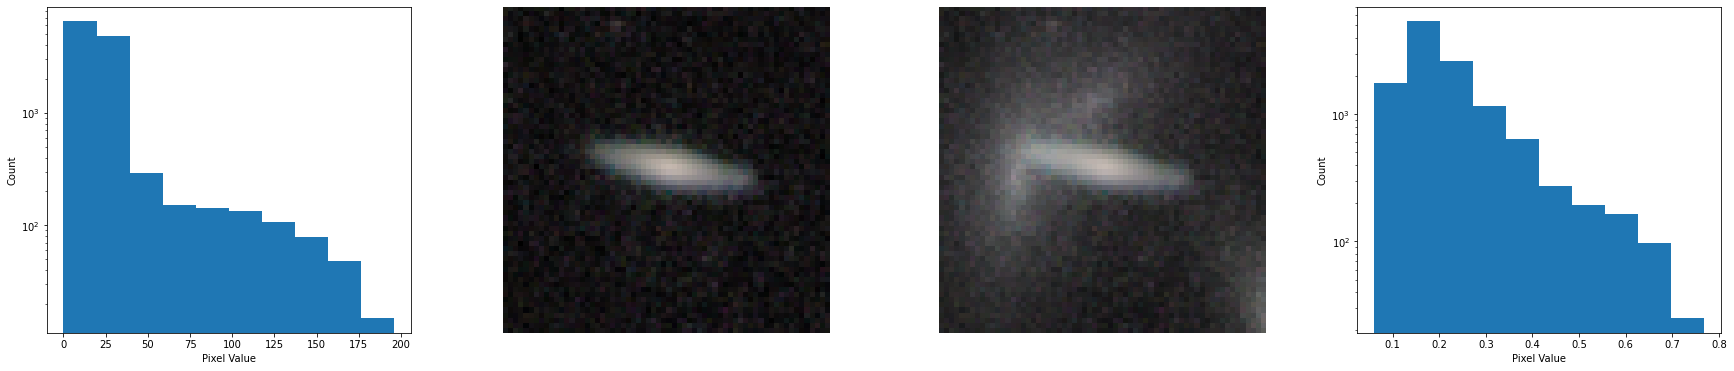

In [4]:
# Plot original image and transoformed image
number_of_examples = 3
transform_no = 1 

for idx in range(number_of_examples):
    next_iter = next(train_no_augmentation)
    image = next_iter['image']
    target = next_iter['label']
    
    fig, ax = plt.subplots(1,transform_no+3, figsize=((transform_no+3)*7.5,6))
    image = np.asarray(image)
    ax[0].hist(image.squeeze().flatten())
    ax[0].set_yscale('log')
    ax[0].set_xlabel("Pixel Value")
    ax[0].set_ylabel("Count")
    
    ax[1].imshow(image.squeeze(), cmap="Greys_r")
    ax[1].axis('off')
    
    for i in range(transform_no):
        image = custom_transform(image=image)['image']
        ax[i+2].imshow(image, cmap="Greys_r")
        ax[i+2].axis('off')
    ax[transform_no+2].hist(image.squeeze().flatten())
    ax[transform_no+2].set_yscale('log')
    ax[transform_no+2].set_xlabel("Pixel Value")
    ax[transform_no+2].set_ylabel("Count")
    
    plt.show()
    if idx>=number_of_examples-1:
        break

# Using Augmentations in a pipeline (optional)

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
dl_config = tfds.download.DownloadConfig(
                extract_dir='./data/GalaxyMNIST/raw')
ds = tfds.load('GalaxyMNIST', data_dir='./data', download=True,
               download_and_prepare_kwargs={'download_dir':'./data/GalaxyMNIST/raw',
                                            'download_config':dl_config})
train_no_augmentation = ds['train']

In [7]:
#transform = A.Compose([
#    A.Lambda(
#        name='AA.composed.ImgOptical',
#        image=AA.composed.ImgOptical(
#            dataset=train_no_augmentation
#        ),
#        always_apply=True
#    )
#])
transform = A.Compose([
    A.ToFloat(),
    A.Lambda(
        name='Adding Simulated Sources',
        image=AA.optical.SuperimposeSources(
            mode='sersic'
        ), p=1)
])

def aug_fn(image):
    data = {"image":image}
    aug_data = transform(**data)
    aug_img = aug_data["image"]
    
    return aug_img.astype(np.float32)

def process_data(inputs):
    image = inputs['image']
    label = inputs['label']
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32, name='augment')
    return {'image':aug_img, 'label':label}

train = ds['train'].map(process_data, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
train_iter = iter(train)

img = next(train_iter)['image']
print(img.shape)

(64, 64, 3)


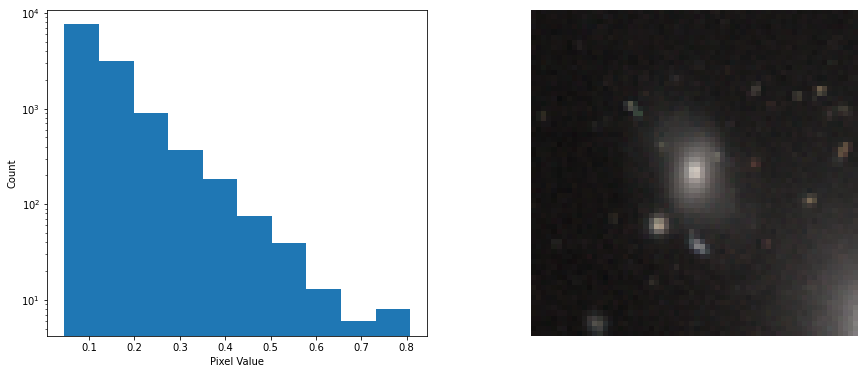

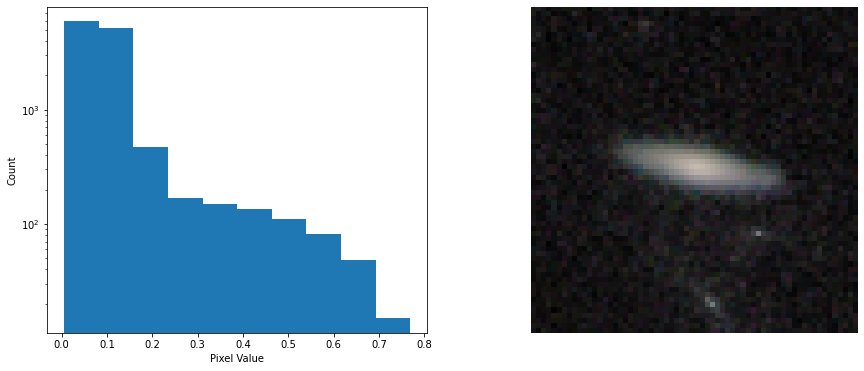

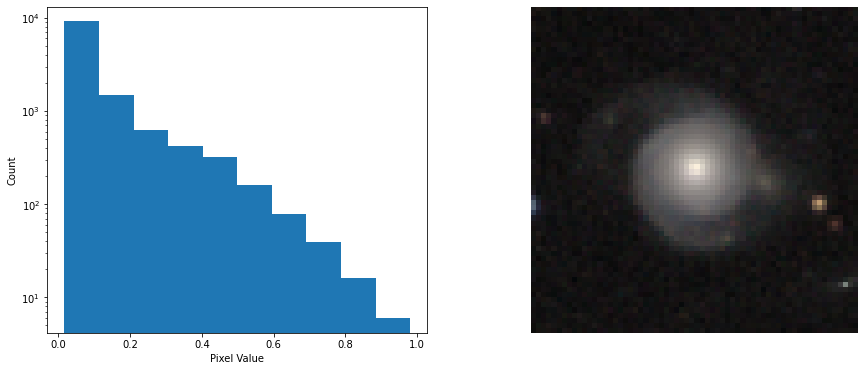

In [8]:
number_of_examples=3
for idx in range(number_of_examples):
    next_iter = next(train_iter)
    image = next_iter['image']
    target = next_iter['label']
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    
    image = np.asarray(image)
    ax[0].hist(image.squeeze().flatten())
    ax[0].set_yscale('log')
    ax[0].set_xlabel("Pixel Value")
    ax[0].set_ylabel("Count")

    ax[1].imshow(image.squeeze(), cmap="Greys_r")
    ax[1].axis('off')

    plt.show()
    if idx>=number_of_examples-1:
        break